## Environment Initialization

In your terminal window, do the following:
1. export GOOGLE_APPLICATION_CREDENTIALS="/Users/Chenlin/icloud/data_science/python/[FILE_NAME].json"
2. pip install --upgrade google-cloud-bigquery[pandas]
3. jupyter notebook (you launch jupyter notebook in the end)

In [6]:
%load_ext google.cloud.bigquery

In [2]:
from google.cloud import bigquery

In [3]:
bigquery_client = bigquery.Client()

To retrieve query results as a pandas.DataFrame:<br>
sql = """
SELECT xxx ...
"""<br>
df = bigquery_client.query(sql).to_dataframe()

# Ford GoBike Analysis
Problem Statement: You're a data scientist at Ford GoBike (https://www.fordgobike.com/), the company running Bay Area Bikeshare. You are trying to increase ridership, and you want to offer deals through the mobile app to do so. What deals do you offer though? Currently, your company has three options: a flat price for a single one-way trip, a day pass that allows unlimited 30-minute rides for 24 hours and an annual membership.

## Import necessary packages

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pandas.api.types import CategoricalDtype

%matplotlib inline

## How many trips? Who made those Trips? When were those trips made?

In [10]:
%%bigquery
SELECT 
    COUNT(Subscriber_trip) Subscriber_Trips, 
    COUNT(Customer_trip) Customer_Trips, 
    COUNT(*) Total_Trips
FROM 
    (SELECT 
        CASE WHEN subscriber_type = 'Subscriber' THEN 1 END Subscriber_trip, 
        CASE WHEN subscriber_type = 'Customer' THEN 1 END Customer_trip 
    FROM 
        `bigquery-public-data.san_francisco.bikeshare_trips`)

,Subscriber_Trips,Customer_Trips,Total_Trips
0,846839,136809,983648


In [14]:
# Same as above but load query result to df

sql = """
SELECT 
    COUNT(Subscriber_trip) Subscriber_Trips, 
    COUNT(Customer_trip) Customer_Trips, 
    COUNT(*) Total_Trips
FROM 
    (SELECT 
        CASE WHEN subscriber_type = 'Subscriber' THEN 1 END Subscriber_trip, 
        CASE WHEN subscriber_type = 'Customer' THEN 1 END Customer_trip 
    FROM 
        `bigquery-public-data.san_francisco.bikeshare_trips`)
"""

df = bigquery_client.query(sql).to_dataframe()
df

,Subscriber_Trips,Customer_Trips,Total_Trips
0,846839,136809,983648


#### Subscriber trips by day of week and hour of day 

In [64]:
dow_dict = {
    1: "Sunday",
    2: "Monday",
    3: "Tuesday",
    4: "Wednesday",
    5: "Thursday",
    6: "Friday",
    7: "Saturday"
}

dow = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

In [59]:
sql = """
SELECT 
    EXTRACT (DAYOFWEEK FROM start_date) Day_of_Week,
    EXTRACT (HOUR FROM start_date) HOUR,
    COUNT(*) Number_of_Trips
FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
    subscriber_type = 'Subscriber'
GROUP BY
    1,2"""

sub_trips_hourly = bigquery_client.query(sql).to_dataframe()

In [60]:
sub_trips_hourly.head()

,Day_of_Week,HOUR,Number_of_Trips
0,4,15,6125
1,6,16,13746
2,7,11,2634
3,7,12,2663
4,2,7,12641


In [68]:
sub_trips_hourly['Day_of_Week'] = sub_trips_hourly['Day_of_Week'].replace(dow_dict)
sub_trips_hourly['Day_of_Week'] = sub_trips_hourly['Day_of_Week'].astype(CategoricalDtype(dow, ordered=True))
sub_trips_hourly.head()

,Day_of_Week,HOUR,Number_of_Trips
0,Wednesday,15,6125
1,Friday,16,13746
2,Saturday,11,2634
3,Saturday,12,2663
4,Monday,7,12641


In [69]:
sub_hourly = sub_trips_hourly.groupby(['HOUR', 'Day_of_Week']).sum().unstack()

Text(69,0.5,'Hour of Day')

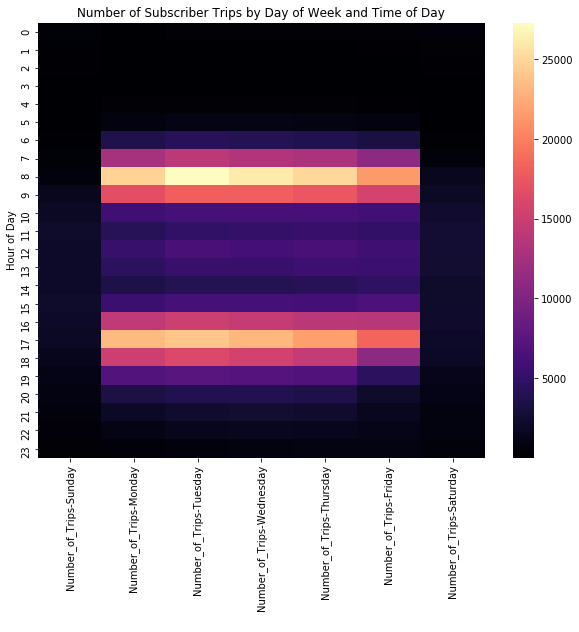

In [70]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(sub_hourly, cmap='magma')

plt.title('Number of Subscriber Trips by Day of Week and Time of Day')
plt.xlabel(' ')
plt.ylabel('Hour of Day')

In [92]:
sql = """
SELECT 
    EXTRACT (DAYOFWEEK FROM start_date) Day_of_Week,
    EXTRACT (HOUR FROM start_date) HOUR,
    COUNT(*) Number_of_Trips
FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
    subscriber_type = 'Customer'
GROUP BY
    1,2"""

cus_trips_hour = bigquery_client.query(sql).to_dataframe()

In [93]:
cus_trips_hour['Day_of_Week'] = cus_trips_hour['Day_of_Week'].replace(dow_dict)
cus_trips_hour['Day_of_Week'] = cus_trips_hour['Day_of_Week'].astype(CategoricalDtype(dow, ordered=True))
cus_trips_hour.head()

,Day_of_Week,HOUR,Number_of_Trips
0,Wednesday,15,1260
1,Friday,11,1630
2,Saturday,11,2567
3,Saturday,12,3063
4,Friday,2,43


In [94]:
cus_hourly = cus_trips_hour.groupby(['HOUR', 'Day_of_Week']).sum().unstack()

Text(69,0.5,'Hour of Day')

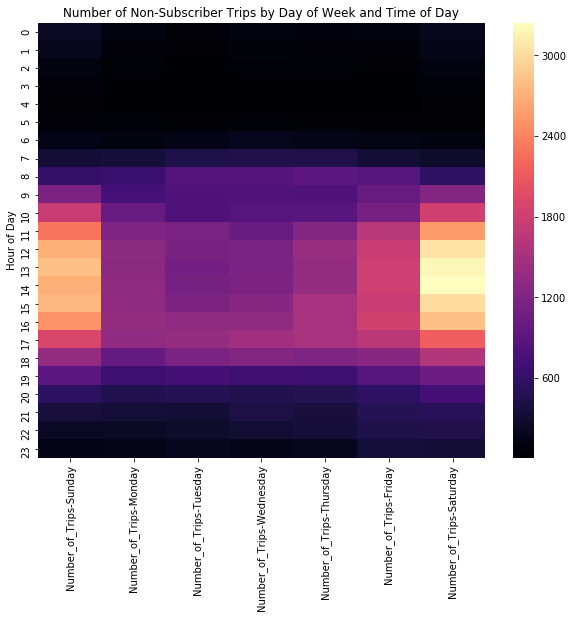

In [96]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(cus_hourly, cmap='magma')

plt.title('Number of Non-Subscriber Trips by Day of Week and Time of Day')
plt.xlabel(' ')
plt.ylabel('Hour of Day')

## Number of Trips by Time

Trips by year

In [135]:
%%bigquery
SELECT
    EXTRACT(YEAR FROM start_date) Year,
    subscriber_type Member_Type,
    FORMAT("%'d",COUNT(*)) Number_Of_Trips
FROM 
    `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY 
    Year, Member_Type
ORDER BY
    Year

,Year,Member_Type,Number_Of_Trips
0,2013,Customer,"24,499"
1,2013,Subscriber,"76,064"
2,2014,Customer,"48,576"
3,2014,Subscriber,"277,763"
4,2015,Subscriber,"305,722"
5,2015,Customer,"40,530"
6,2016,Customer,"23,204"
7,2016,Subscriber,"187,290"


Trips by Month 

In [137]:
%%bigquery
SELECT
    FORMAT_DATE("%B", DATE(start_date)) Month,
    subscriber_type Member_Type,
    FORMAT("%'d",COUNT(*)) Number_Of_Trips
FROM 
    `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY 
    Month, Member_Type
ORDER BY
    2 DESC

,Month,Member_Type,Number_Of_Trips
0,September,Subscriber,"70,011"
1,May,Subscriber,"73,623"
2,January,Subscriber,"64,075"
3,March,Subscriber,"71,619"
4,February,Subscriber,"62,123"
5,June,Subscriber,"79,525"
6,August,Subscriber,"80,033"
7,April,Subscriber,"74,218"
8,October,Subscriber,"80,340"
9,December,Subscriber,"51,165"


Combining the two together!

In [139]:
%%bigquery
SELECT
    FORMAT_DATE("%B", DATE(start_date)) Month,
    FORMAT("%'d", COUNT(*)) Total_Trips,
    FORMAT("%'d", COUNT(subscriber_trip)) Subscriber_Trips,
    FORMAT("%'d", COUNT(customer_trip)) Customer_Trips
FROM (
    SELECT
        start_date,
        CASE WHEN subscriber_type = "Customer" THEN 1 END customer_trip,
        CASE WHEN subscriber_type = "Subscriber" THEN 1 END subscriber_trip
    FROM
        `bigquery-public-data.san_francisco.bikeshare_trips`)
GROUP BY 1
ORDER BY 2 DESC


,Month,Total_Trips,Subscriber_Trips,Customer_Trips
0,August,"95,576","80,033","15,543"
1,October,"94,378","80,340","14,038"
2,June,"91,672","79,525","12,147"
3,July,"89,539","76,387","13,152"
4,September,"87,321","70,011","17,310"
5,May,"86,364","73,623","12,741"
6,April,"84,196","74,218","9,978"
7,March,"81,777","71,619","10,158"
8,November,"73,091","63,720","9,371"
9,January,"71,788","64,075","7,713"


AM Peak Trips

In [154]:
%%bigquery
SELECT
    FORMAT("%'d", COUNT(*)) Number_of_Trips,
    ROUND(AVG(duration_sec/60)) Average_Duration_Min,
    COUNT(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips`) Trip_Percentage
FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
    EXTRACT(HOUR FROM start_date) > 6 AND EXTRACT(HOUR FROM start_date) < 9

,Number_of_Trips,Average_Duration_Min,Trip_Percentage
0,"199,995",11.0,0.20332


PM Peak Trips

In [155]:
%%bigquery
SELECT
    FORMAT("%'d", COUNT(*)) Number_of_Trips,
    ROUND(AVG(duration_sec/60)) Average_Duration_Min,
    COUNT(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips`) Trip_Percentage
FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
    EXTRACT(HOUR FROM start_date) > 16 AND EXTRACT(HOUR FROM start_date) < 19

,Number_of_Trips,Average_Duration_Min,Trip_Percentage
0,"210,871",13.0,0.214376


Trip by Hour

In [156]:
%%bigquery
SELECT 
    EXTRACT(HOUR FROM start_date) Hour,
    COUNT(*) Number_of_Trips,
    COUNT(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips`) Trip_Percentage,
    ROUND(AVG(duration_sec/60)) Average_Duration_Min
FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY 1
ORDER BY 1

,Hour,Number_of_Trips,Trip_Percentage,Average_Duration_Min
0,0,2929,0.002978,27.0
1,1,1611,0.001638,49.0
2,2,877,0.000892,73.0
3,3,605,0.000615,136.0
4,4,1398,0.001421,20.0
5,5,5098,0.005183,18.0
6,6,20519,0.020860,14.0
7,7,67531,0.068654,11.0
8,8,132464,0.134666,11.0
9,9,96118,0.097716,13.0


### Popular Routes

In [162]:
%%bigquery
SELECT 
    t.start_station_name StationName, 
    s.latitude start_lat, 
    s.longitude start_lon, 
    e.latitude end_lat, 
    e.longitude end_lon, 
    count(*) AS NumTrips
FROM 
    `bigquery-public-data.san_francisco.bikeshare_trips` t
JOIN 
    `bigquery-public-data.san_francisco.bikeshare_stations` s
ON 
    t.start_station_id = s.station_id
JOIN 
    `bigquery-public-data.san_francisco.bikeshare_stations` e
ON 
    t.end_station_id = e.station_id
GROUP BY 
    StationName, 
    start_lat, 
    start_lon, 
    end_lat, 
    end_lon
ORDER BY 6 DESC
LIMIT 10

,StationName,start_lat,start_lon,end_lat,end_lon,NumTrips
0,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,37.804770,-122.403234,9150
1,San Francisco Caltrain 2 (330 Townsend),37.776600,-122.395470,37.771058,-122.402717,8508
2,2nd at Townsend,37.780526,-122.390288,37.795392,-122.394203,7620
3,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,37.780526,-122.390288,6888
4,Embarcadero at Sansome,37.804770,-122.403234,37.794139,-122.394434,6874
5,Townsend at 7th,37.771058,-122.402717,37.776600,-122.395470,6836
6,Embarcadero at Folsom,37.791464,-122.391034,37.776617,-122.395260,6351
7,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,37.795392,-122.394203,6215
8,Steuart at Market,37.794139,-122.394434,37.780526,-122.390288,6039
9,Steuart at Market,37.794139,-122.394434,37.776617,-122.395260,5959


In [4]:
%%bigquery popular_trips
SELECT 
    t.start_station_name, 
    t.end_station_name, 
    s.latitude start_lat, 
    s.longitude start_lon, 
    e.latitude end_lat, 
    e.longitude end_lon, 
    count(*) NumTrips
FROM `bigquery-public-data.san_francisco.bikeshare_trips` t
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` s
ON t.start_station_id = s.station_id
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` e
ON t.end_station_id = e.station_id
GROUP BY t.start_station_name, t.end_station_name, s.latitude, s.longitude, e.latitude, e.longitude
ORDER BY count(*) DESC

In [10]:
popular_trips

,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,NumTrips
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,37.795392,-122.394203,37.804770,-122.403234,9150
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,37.776600,-122.395470,37.771058,-122.402717,8508
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),37.780526,-122.390288,37.795392,-122.394203,7620
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,37.795392,-122.394203,37.780526,-122.390288,6888
4,Embarcadero at Sansome,Steuart at Market,37.804770,-122.403234,37.794139,-122.394434,6874
5,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),37.771058,-122.402717,37.776600,-122.395470,6836
6,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),37.791464,-122.391034,37.776617,-122.395260,6351
7,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),37.776617,-122.395260,37.795392,-122.394203,6215
8,Steuart at Market,2nd at Townsend,37.794139,-122.394434,37.780526,-122.390288,6039
9,Steuart at Market,San Francisco Caltrain (Townsend at 4th),37.794139,-122.394434,37.776617,-122.395260,5959


### Most popular Stations

In [166]:
%%bigquery
SELECT 
    station.name AS Station,
    count(*) Number_of_Trips
FROM
    `bigquery-public-data.san_francisco.bikeshare_stations` station
INNER JOIN
    `bigquery-public-data.san_francisco.bikeshare_trips` trip
ON
    station.station_id = trip.start_station_id
GROUP BY
    Station
ORDER BY
    2 DESC
LIMIT 10

,Station,Number_of_Trips
0,San Francisco Caltrain (Townsend at 4th),72683
1,San Francisco Caltrain 2 (330 Townsend),56100
2,Harry Bridges Plaza (Ferry Building),49062
3,Embarcadero at Sansome,41137
4,2nd at Townsend,39936
5,Temporary Transbay Terminal (Howard at Beale),39200
6,Steuart at Market,38531
7,Market at Sansome,35142
8,Townsend at 7th,34894
9,Market at 10th,30209
